# 커스텀 프로젝트 직접 만들기

## 프로젝트 설명

GLUE benchmark의 한국어 버전인 KLUE benchmark를 사용한 모델을 활용하여 NSMC(Naver Sentiment Movie Corpus) task의 성능을 높이는 것에 도전한다.
1. NSMC 데이터 분석
2. Huggingface dataset 구성
3. klue/bert-base model 및 tokenizer 불러오기
4. 데이터셋 전처리
5. 모델 학습 진행
6. Fine-tuning을 통해 모델 성능(accuracy) 향상
7. Bucketing을 적용하여 학습시키고 6의 결과와 비교

## 실험 가능한 요소 정리

### 실험 1 : bucketing이 모델 성능에 영향을 크게 줄 것이다.
- fine-tuning 만 진행한 baseline
- bucketing 추가한 모델

### 실험 2 : max_len 전처리한 데이터에서도 bucketing이 모델 성능에 영향을 줄 것이다.
- max_len = 95로 설정하여 초과분을 잘라낸 데이터
- max_len을 사용하여 fine-tuning을 진행한 baseline
- bucketing 추가한 모델

### 실험 3 : max_len으로 전처리한 데이터가 모델 성능에 영향을 줄 것이다.
- max_len = 95로 설정하여 초과분을 잘라낸 데이터
- 문장 전체 길이를 사용하여 fine-tuning 만 진행한 baseline
- max_len을 사용하여 fine-tuning을 진행한 모델

## 프로젝트 루브릭

|학습 목표|평가 기준|
|---------|---------|
|모델과 데이터를 정상적으로 불러오고, 작동하는 것을 확인하였다.|klue/bert-base를 NSMC 데이터셋으로 fine-tuning 하여, 모델이 정상적으로 작동하는 것을 확인하였다.|
|Preprocessing을 개선하고, fine-tuning을 통해 모델의 성능을 개선시켰다.|Validation accuracy를 90% 이상으로 개선하였다.|
|모델 학습에 Bucketing을 성공적으로 적용하고, 그 결과를 비교분석하였다.|Bucketing task을 수행하여 fine-tuning 시 연산 속도와 모델 성능 간의 trade-off 관계가 발생하는지 여부를 확인하고, 분석한 결과를 제시하였다.|

# 사전 환경 세팅

## 환경 세팅

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/
!mkdir -p ./work/huggingface
%cd ./work/huggingface
!sudo apt-get update
!sudo apt-get install -y fonts-nanum fonts-noto-cjk
!fc-list | grep -i "nanum\|noto"
!pip install sentencepiece
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install evaluate
!pip install seaborn

/content/drive/MyDrive/AIFFEL/Deep_Dive
/content/drive/MyDrive/AIFFEL/Deep_Dive/work/huggingface
Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,535 kB]
Fetched 3,664 kB in 2s (1,976 kB/s)
Read

In [ ]:
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('I love you'))"

2025-12-02 12:06:44.878190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 12:06:44.896797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764677204.919155   79744 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764677204.929787   79744 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764677204.947671   79744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis', model='klue/bert-base')('나는 너를 사랑해'))"

2025-12-02 12:07:01.159113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 12:07:01.178649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764677221.203386   79889 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764677221.210015   79889 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764677221.231822   79889 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# 라이브러리 설치 및 호출

## 라이브러리 호출

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


In [ ]:
import wandb
wandb.login(key="YOUR_API_KEY") # 사용할 때는 weights&bias 회원가입 후 생성되는 API 키 사용

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jylee4747 (jylee4747-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd
import seaborn as sns

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

import datasets
from datasets import load_dataset, Dataset

import evaluate
from evaluate import load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 라이브러리 버전 확인

In [ ]:
print(torch.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.9.0+cu126
2.0.2
4.57.2
4.0.0


# Huggingface dataset 구성

In [ ]:
huggingface_nsmc_dataset = load_dataset("Blpeng/nsmc")
print(huggingface_nsmc_dataset)

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 50000
    })
})


In [ ]:
hf_nsmc_train_df = huggingface_nsmc_dataset["train"].to_pandas().drop(['Unnamed: 0', 'id'], axis=1)
hf_nsmc_test_df = huggingface_nsmc_dataset["test"].to_pandas().drop(['Unnamed: 0', 'id'], axis=1)

hf_nsmc_train_df.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# klue/bert-base model 및 tokenizer 불러오기

In [ ]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [ ]:
def transform(text):
    return tokenizer(text, return_tensors="pt")

In [ ]:
def get_tokens_from_transform_outputs(outputs):
    input_ids = outputs["input_ids"][0]          # tensor shape: [seq_len]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())
    return tokens

In [ ]:
inputs = transform("안녕하세요. 제 고양이는 귀여워요. 굳굿 good GOOD ^^ @@!!!!")
print(inputs)
id_tokens = get_tokens_from_transform_outputs(inputs)
print(id_tokens)

{'input_ids': tensor([[    2,  5891,  2205,  5971,    18,  1545,  7003,  2259, 16612,  2182,
            18,   618,  2673, 23025, 22349, 17527,    65,    65,    36,    36,
             5,     5,     5,     5,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}
['[CLS]', '안녕', '##하', '##세요', '.', '제', '고양이', '##는', '귀여워', '##요', '.', '굳', '##굿', 'good', 'GO', '##OD', '^', '^', '@', '@', '!', '!', '!', '!', '[SEP]']


In [ ]:
inputs['input_ids']

tensor([[    2,  5891,  2205,  5971,    18,  1545,  7003,  2259, 16612,  2182,
            18,   618,  2673, 23025, 22349, 17527,    65,    65,    36,    36,
             5,     5,     5,     5,     3]])

# 데이터 분석

## 결측치 확인 및 처리

In [ ]:
df = hf_nsmc_train_df
hf_nsmc_train_df.replace(np.nan, r"^\s*$", regex=True, inplace=True)
hf_nsmc_train_df.isnull().sum()

,0
document,0
label,0


## 중복값 제거

In [ ]:
dupes = hf_nsmc_train_df[hf_nsmc_train_df.duplicated(keep=False)]
dupes.sort_values(by="document").groupby("document").head()

,document,label
28313,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
13624,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
123606,",",1
139045,",",1
31291,",,,",0
...,...,...
64332,흥.,0
81256,흥미진진,1
135586,흥미진진,1
8446,힐러리 더프의 매력에 빠지다!!!,1


In [ ]:
hf_nsmc_train_df["document"].value_counts().loc[lambda x: x > 1]

,count
document,
굿,181
good,92
최고,85
쓰레기,79
별로,66
...,...
최악....,2
빛 좋은 개살구,2
최악의 영화.,2


In [ ]:
train_df = hf_nsmc_train_df.drop_duplicates(subset=["document"], keep="first").reset_index(drop=True)
train_df["document"].value_counts().loc[lambda x: x > 1]

,count
document,


## 데이터 시각화

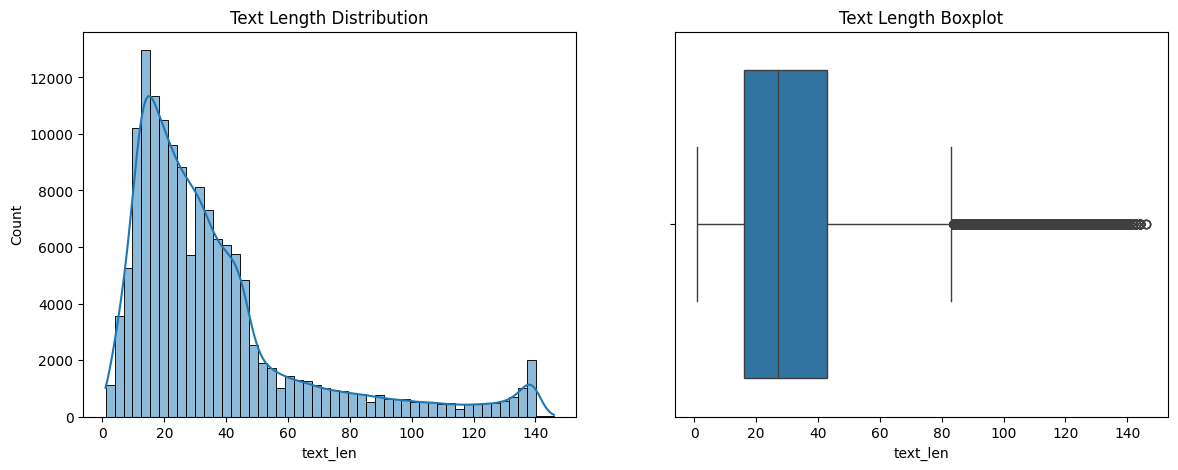

In [ ]:
train_df["text_len"] = train_df["document"].astype(str).apply(len)

plt.figure(figsize=(14,5))

# 히스토그램
plt.subplot(1,2,1)
sns.histplot(train_df["text_len"], bins=50, kde=True)
plt.title("Text Length Distribution")

# 박스플롯
plt.subplot(1,2,2)
sns.boxplot(x=train_df["text_len"])
plt.title("Text Length Boxplot")

plt.show()

# 데이터 전처리

- 문장 단위 전처리 함수 정의
    - 반복되는 문장 부호 제거
    - 문장 부호만 존재하는 데이터는 빈 문자열 처리
    - 맞춤법 변형 통일
    - 반복 문자 제거
    - 완성형 한글 필터링
    - 이모지, 이모티콘, 특수문자 제거
    - 영어 소문자 변환
    - 등등
- tokenizer 결정 및 데이터 토큰화
- stopword 정의
- max_len 결정

In [ ]:
SPELLING_DICT = {
    '굳': ['궅', '굳', '굿'],
    '미쳤': ['미첫', '미쳣', '미첬', '미쳤', 'ㅁㅊ'],
    '괜찮': ['괜찮', '괜춘', '괜찬', 'ㄱㅊ', '갠찬', '갠찮', '괸찬', '괸찮'],
    '최고': ['쵝오', '최고'],
    '봤': ['봣'],
    '겠': ['겟']
}

PUNCT = r"[.!?…;]"


def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 반복되는 문장 부호 제거 (예: "!!!" → "!")
    text = re.sub(rf"({PUNCT})\1+", r"\1", text)

    # 문장부호만 있는 경우 빈 문자열로 처리
    if re.fullmatch(rf"{PUNCT}+", text.strip()):
        return ""

    # 2. 맞춤법 변형 통일
    for correct, variations in SPELLING_DICT.items():
        for v in variations:
            text = text.replace(v, correct)

    # 3. 반복 문자 제거 (2회 이상 → 1회)
    # "ㅋㅋㅋㅋ" → "ㅋ", "하하하" → "하"
    text = re.sub(r"(.)\1+", r"\1", text)

    # 4. 자음/모음 단독 제거
    text = re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", " ", text)

    # 5. 이모지/특수문자 제거
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,]", " ", text)

    # 6. 영어 소문자로 변환
    text = text.lower()

    # 7. 공백 정리
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
train_df["clean_text"] = train_df['document'].apply(preprocess_text)

# 4) clean_text → transform → input_ids → tokens 저장
train_df["tokens"] = train_df["clean_text"].apply(
    lambda t: get_tokens_from_transform_outputs(transform(t))
)

train_df["tokens_len"] = train_df["tokens"].apply(len)

## 빈 문자열, 길이가 너무 짧은 것, unk 토큰만 존재하는 데이터 제거

In [ ]:
def drop_short_and_unk_only(df):
    df = df[df["tokens_len"] >= 3].copy()
    df = df[
        ~(
            (df["tokens_len"] == 3) &
            (df["tokens"].apply(lambda x: x == ['[CLS]', '[UNK]', '[SEP]']))
        )
    ].copy()
    return df

In [ ]:
train_df = drop_short_and_unk_only(train_df)
train_df.head()

,document,label,text_len,clean_text,tokens,tokens_len
0,아 더빙.. 진짜 짜증나네요 목소리,0,19,아 더빙. 진짜 짜증나네요 목소리,"[[CLS], 아, 더, ##빙, ., 진짜, 짜증, ##나, ##네, ##요, 목...",12
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33,흠.포스터보고 초딩영화줄.오버연기조차 가볍지 않구나,"[[CLS], 흠, ., 포스터, ##보, ##고, 초딩, ##영화, ##줄, .,...",20
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29,교도소 이야기구먼 .솔직히 재미는 없다.평점 조정,"[[CLS], 교도소, 이야기, ##구, ##먼, ., 솔직히, 재미, ##는, 없...",15
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,"[[CLS], 사이, ##몬, ##페, ##그, ##의, 익살, ##스, ##런, ...",36
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,45,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화. .별반개도 아까움.,"[[CLS], 막, 걸음마, [UNK], 3, ##세, ##부터, 초등, ##학교,...",26


## 데이터 시각화

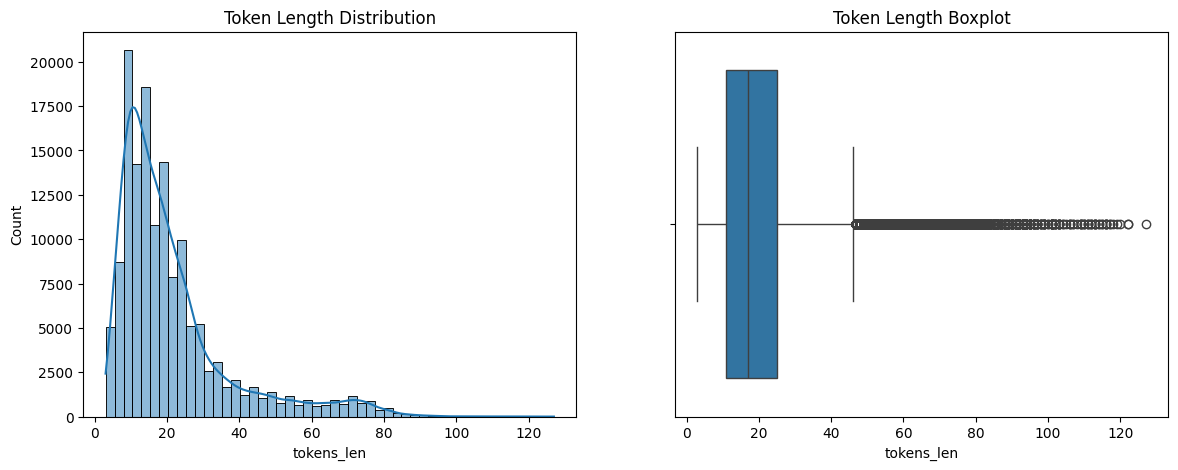

In [ ]:
plt.figure(figsize=(14,5))

# 히스토그램
plt.subplot(1,2,1)
sns.histplot(train_df["tokens_len"], bins=50, kde=True)
plt.title("Token Length Distribution")

# 박스플롯
plt.subplot(1,2,2)
sns.boxplot(x=train_df["tokens_len"])
plt.title("Token Length Boxplot")

plt.show()

## Max Length 설정하기

### Coverage 계산하기

In [ ]:
def get_length_by_coverage(df, coverage):
    """
    coverage(%)를 넣으면 해당 coverage를 만족하는 문장 길이(tokens_len)를 반환.
    예: coverage=90 → 90% 문장 길이가 이 이하임.
    """
    # coverage를 0~1 비율로 변환
    p = coverage / 100

    # tokens_len percentile 계산
    length = df["tokens_len"].quantile(p)

    return int(length)

In [ ]:
cov = [75, 80, 85, 90, 95, 98, 99, 99.5, 99.6, 99.7, 99.8, 99.9, 99.99, 99.999, 100]

for c in cov:
    length = get_length_by_coverage(train_df, c)
    print(f"{c}% coverage: {length}")

75% coverage: 25
80% coverage: 28
85% coverage: 33
90% coverage: 43
95% coverage: 60
98% coverage: 73
99% coverage: 78
99.5% coverage: 82
99.6% coverage: 83
99.7% coverage: 85
99.8% coverage: 87
99.9% coverage: 92
99.99% coverage: 114
99.999% coverage: 122
100% coverage: 127


In [ ]:
max_len = 95   # 예시 값, 원하는 값으로 설정

num_exceed = (train_df["tokens_len"] > max_len).sum()

print("max_len 초과 데이터 개수:", num_exceed)

max_len 초과 데이터 개수: 90


## max_len 기준으로 데이터 자르기

In [ ]:
train_full_df = train_df[['clean_text', 'label']].copy()
train_full_df.head()

,clean_text,label
0,아 더빙. 진짜 짜증나네요 목소리,0
1,흠.포스터보고 초딩영화줄.오버연기조차 가볍지 않구나,1
3,교도소 이야기구먼 .솔직히 재미는 없다.평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화. .별반개도 아까움.,0


In [ ]:
train_len_95_df = train_df[train_df["tokens_len"] <= max_len][["clean_text", "label"]].copy()
train_len_95_df.head()

,clean_text,label
0,아 더빙. 진짜 짜증나네요 목소리,0
1,흠.포스터보고 초딩영화줄.오버연기조차 가볍지 않구나,1
3,교도소 이야기구먼 .솔직히 재미는 없다.평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화. .별반개도 아까움.,0


# 가설 설정

## 실험 1 : bucketing이 모델 성능에 영향을 크게 줄 것이다.
통제 변인 : 학습 환경, 사용한 pretrained model, 토큰화 방식, max_len 사용 여부

종속 변인 : bucketing 유무

실험 방법 : group_by_length의 값을 True, False로 지정하여 accuracy, 실행 시간 등을 비교한다.

## 실험 2 : max_len 전처리한 데이터에서도 bucketing이 모델 성능에 영향을 줄 것이다.
통제 변인 : 학습 환경, 사용한 pretrained model, 토큰화 방식, max_len 사용 여부

종속 변인 : bucketing 유무

실험 방법 : max_len을 사용하여 데이터의 길이가 너무 긴 것은 잘라낸 뒤 group_by_length의 값을 True, False로 지정하여 accuracy, 실행 시간 등을 비교한다.

## 실험 3 : max_len으로 전처리한 데이터가 모델 성능에 영향을 줄 것이다.
통제 변인 : 학습 환경, 사용한 pretrained model, 토큰화 방식, bucketing 유무

종속 변인 : max_len 사용 여부

실험 방법 : max_len을 사용하여 데이터의 길이가 너무 긴 것은 잘라낸 뒤 전체 문장을 사용한 모델과 accuracy, 실행 시간 등을 비교한다.

## KLUE/bert-base 모델 사용한 fine tuning


### Training Arguments 정의 함수

In [ ]:
output_dir = './model'

def make_training_args(output_dir: str, group_by_length: bool, run_name: str):
    return TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        report_to="wandb",      # wandb 쓰기 싫으면 "none"으로 변경
        group_by_length=group_by_length,
        #length_column_name="input_ids",  # input_ids 길이로 버킷팅
        run_name=run_name,
    )

In [ ]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    return_tensors="pt",
)

## train-test split

In [ ]:
def make_tokenized_datasets(
    use_full_df: bool = True,
    test_size: float = 0.2,
    random_state: int = 42,
    stratify: bool = True,
):
    """
    use_full_df=True  -> train_full_df 사용
    use_full_df=False -> train_len_95_df 사용

    반환: (train_dataset, valid_dataset)
      - 각 샘플: {"input_ids", "attention_mask", (optional) "token_type_ids", "labels"}
      - 아직 torch 포맷 아님 (python 리스트 상태)
    """
    # 1) 어느 df 쓸지 선택
    base_df = train_full_df if use_full_df else train_len_95_df

    # 2) stratify 여부
    stratify_col = base_df["label"] if stratify else None

    # 3) split
    train_df, valid_df = train_test_split(
        base_df,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=stratify_col,
    )

    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)

    # 4) 텍스트 / 라벨 리스트 추출
    train_texts = train_df["clean_text"].tolist()
    valid_texts = valid_df["clean_text"].tolist()
    train_labels = train_df["label"].tolist()
    valid_labels = valid_df["label"].tolist()

    # 5) 토크나이징 (padding, truncation 여기선 안 씀: collator가 처리)
    train_enc = tokenizer(train_texts)
    valid_enc = tokenizer(valid_texts)

    # 6) HF Dataset으로 변환 (python 포맷 유지)
    train_dict = {
        "input_ids": train_enc["input_ids"],
        "attention_mask": train_enc["attention_mask"],
        "labels": train_labels,
    }
    valid_dict = {
        "input_ids": valid_enc["input_ids"],
        "attention_mask": valid_enc["attention_mask"],
        "labels": valid_labels,
    }

    if "token_type_ids" in train_enc:
        train_dict["token_type_ids"] = train_enc["token_type_ids"]
        valid_dict["token_type_ids"] = valid_enc["token_type_ids"]

    train_dataset = Dataset.from_dict(train_dict)
    valid_dataset = Dataset.from_dict(valid_dict)

    # ❌ set_format("torch") 절대 하지 말 것 (bucketing 때문에)
    return train_dataset, valid_dataset

In [ ]:
# 1) full 데이터
train_dataset_full, valid_dataset_full = make_tokenized_datasets(
    use_full_df=True,
    test_size=0.2,
)

# 2) len95 데이터
train_dataset_95, valid_dataset_95 = make_tokenized_datasets(
    use_full_df=False,
    test_size=0.2,
)

## 모델 평가 지표 함수 정의

In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

## test data 생성

In [ ]:
# HuggingFace test → pandas
test_df = huggingface_nsmc_dataset["test"].to_pandas()
test_df = test_df[["document", "label"]].copy()
test_df["clean_text"] = test_df["document"].apply(preprocess_text)

def make_tokenized_test_dataset(test_df):
    texts = test_df["clean_text"].tolist()
    labels = test_df["label"].tolist()

    enc = tokenizer(texts)

    data = {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": labels,
    }
    if "token_type_ids" in enc:
        data["token_type_ids"] = enc["token_type_ids"]

    test_dataset = Dataset.from_dict(data)
    return test_dataset   # 여기도 set_format 안 함

test_dataset = make_tokenized_test_dataset(test_df)

In [ ]:
# HF test split 불러오기
test_df = huggingface_nsmc_dataset["test"].to_pandas()

# 필요한 컬럼만 선택
test_df = test_df[["document", "label"]].copy()

# 전처리
test_df["clean_text"] = test_df["document"].apply(preprocess_text)

# 토크나이즈된 Dataset 만들기
test_dataset = make_tokenized_test_dataset(test_df)

## 모델 학습 함수 정의

In [ ]:
def run_experiment(
    train_dataset,
    valid_dataset,
    test_dataset,
    group_by_length: bool,
    tag: str,
    use_wandb: bool = True,
):
    """
    tag 예: 'full_plain', 'full_bucket', 'len95_plain', 'len95_bucket'
    """

    # 0) wandb run 시작
    if use_wandb:
        wandb.init(
            project="huggingface",  # 네 프로젝트 이름
            name=tag,
            reinit=True,
        )

    # 1) fresh model
    model = AutoModelForSequenceClassification.from_pretrained(
        "klue/bert-base",
        num_labels=2,
    )

    # 2) training_args
    output_dir = f"./model_{tag}"
    training_args = make_training_args(
        output_dir=output_dir,
        group_by_length=group_by_length,
        run_name=tag,
    )

    # 3) Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    print(f"\n=== [{tag}] Training starts ===")
    trainer.train()

    print(f"\n=== [{tag}] Eval on test_dataset ===")
    test_output = trainer.predict(test_dataset)
    print(test_output.metrics)  # {'test_loss': ..., 'test_accuracy': ...}

    if use_wandb:
        wandb.finish()

    return test_output.metrics

# 모델 학습

In [ ]:
results = {}

## baseline 학습
- full-text no bucketing

In [ ]:
# ① full + plain
results["full_plain"] = run_experiment(
    train_dataset=train_dataset_full,
    valid_dataset=valid_dataset_full,
    test_dataset=test_dataset,
    group_by_length=False,
    tag="full_plain",
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== [full_plain] Training starts ===


Epoch,Training Loss,Validation Loss,Accuracy
1,0.295900,0.293806,0.901602
2,0.218200,0.355227,0.904621
3,0.125000,0.456687,0.906920



=== [full_plain] Eval on test_dataset ===


{'test_loss': 0.47828561067581177, 'test_accuracy': 0.9016, 'test_runtime': 75.4354, 'test_samples_per_second': 662.819, 'test_steps_per_second': 82.852}


eval/accuracy,▁▅█
eval/loss,▁▄█
eval/runtime,▁█▆
eval/samples_per_second,█▁▃
eval/steps_per_second,█▁▃
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
+5,...


## case1 학습
- max_len=95 no bucketing

In [ ]:
# ② len95 + plain
results["len95_plain"] = run_experiment(
    train_dataset=train_dataset_95,
    valid_dataset=valid_dataset_95,
    test_dataset=test_dataset,
    group_by_length=False,
    tag="len95_plain",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== [len95_plain] Training starts ===


Epoch,Training Loss,Validation Loss,Accuracy
1,0.299000,0.374585,0.897147
2,0.228600,0.362279,0.904219
3,0.168400,0.480402,0.905180



=== [len95_plain] Eval on test_dataset ===


{'test_loss': 0.48685359954833984, 'test_accuracy': 0.90062, 'test_runtime': 74.0578, 'test_samples_per_second': 675.148, 'test_steps_per_second': 84.394}


eval/accuracy,▁▇█
eval/loss,▂▁█
eval/runtime,▁█▆
eval/samples_per_second,█▁▃
eval/steps_per_second,█▁▃
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
+5,...


## case2 학습
- full-text bucketing

In [ ]:
train_dataset_full = train_dataset_full.with_format("python")
valid_dataset_full = valid_dataset_full.with_format("python")
train_dataset_95 = train_dataset_95.with_format("python")
valid_dataset_95 = valid_dataset_95.with_format("python")


In [ ]:
# ③ full + bucketing
results["full_bucket"] = run_experiment(
    train_dataset=train_dataset_full,
    valid_dataset=valid_dataset_full,
    test_dataset=test_dataset,
    group_by_length=True,
    tag="full_bucket",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== [full_bucket] Training starts ===


Epoch,Training Loss,Validation Loss,Accuracy
1,0.300500,0.312597,0.900024
2,0.233800,0.372226,0.904381
3,0.164400,0.448546,0.905136



=== [full_bucket] Eval on test_dataset ===


{'test_loss': 0.46379855275154114, 'test_accuracy': 0.901, 'test_runtime': 77.5921, 'test_samples_per_second': 644.395, 'test_steps_per_second': 80.549}


eval/accuracy,▁▇█
eval/loss,▁▄█
eval/runtime,▁█▆
eval/samples_per_second,█▁▂
eval/steps_per_second,█▁▂
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
+5,...


## case3 학습
- max_len=95 bucketing

In [ ]:
# ④ len95 + bucketing
results["len95_bucket"] = run_experiment(
    train_dataset=train_dataset_95,
    valid_dataset=valid_dataset_95,
    test_dataset=test_dataset,
    group_by_length=True,
    tag="len95_bucket",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== [len95_bucket] Training starts ===


Epoch,Training Loss,Validation Loss,Accuracy
1,0.319800,0.336873,0.896564
2,0.209600,0.367680,0.904151
3,0.140400,0.471098,0.904082



=== [len95_bucket] Eval on test_dataset ===


{'test_loss': 0.4792880713939667, 'test_accuracy': 0.9005, 'test_runtime': 68.924, 'test_samples_per_second': 725.437, 'test_steps_per_second': 90.68}


eval/accuracy,▁██
eval/loss,▁▃█
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
+5,...


# 결과

In [ ]:
print("\n=== Summary ===")
for k, v in results.items():
    print(k, "->", v)


=== Summary ===
full_plain -> {'test_loss': 0.47828561067581177, 'test_accuracy': 0.9016, 'test_runtime': 75.4354, 'test_samples_per_second': 662.819, 'test_steps_per_second': 82.852}
len95_plain -> {'test_loss': 0.48685359954833984, 'test_accuracy': 0.90062, 'test_runtime': 74.0578, 'test_samples_per_second': 675.148, 'test_steps_per_second': 84.394}
full_bucket -> {'test_loss': 0.46379855275154114, 'test_accuracy': 0.901, 'test_runtime': 77.5921, 'test_samples_per_second': 644.395, 'test_steps_per_second': 80.549}
len95_bucket -> {'test_loss': 0.4792880713939667, 'test_accuracy': 0.9005, 'test_runtime': 68.924, 'test_samples_per_second': 725.437, 'test_steps_per_second': 90.68}


![result_imgs/results1](./result_imgs/results1.png)

전체적으로 다 90% 이상의 정확도를 보였고 loss 또한 0.5 이하로 떨어졌다. 특히 max_len=95로 하여 문장을 잘라낸 것이 전체 문장을 사용한 것 보다 미세하게 낮은 성능을 보였고 loss 또한 0.01 정도 높게 나타났다.

실행 시간을 비교했을 때는 다음과 같다.
|case|학습 소요 시간|
|----|------------|
|full_plain|1:14:56|
|len95_plain|1:14:14|
|full_bucket|0:41:22|
|len95_bucket|0:35:21|

bucketing을 진행하지 않았을 때는 full과 len95가 큰 차이를 보이지 않았으나 bucketing을 진행하자 약 6분 가량의 차이를 보였다. 또한, bucketing 유무에 따른 학습 소요 시간의 차이가 문장 길이 전처리 유무와 관계없이 모두 30분 이상의 큰 차이를 보였다. 이를 토대로 각각 소요시간이 full 44.8%, len95 52.4% 하락했음을 확인하였다.

[Weights&Bias 시각화 대시보드](https://wandb.ai/jylee4747-none/huggingface?nw=nwuserjylee4747)

모델 학습 과정에서 생성되는 메트릭을 자동으로 weights&bias에서 관측하여 시각화를 해 주는 기능이 있어 사용해 보았다.

![result_imgs/results2](./result_imgs/results2.png)

시각화에서 추가적으로 관찰한 사실은 epoch이 끝나고 다음 epoch으로 넘어갈 때마다 loss가 급격하게 줄어들어 계단식으로 감소한다는 것이다.

# 고찰

위 결과를 통해 세 가지 가설에 대한 실험 결과는 다음과 같이 정리할 수 있다.

1. bucketing이 모델 성능에 영향을 크게 줄 것이다.
- accuracy에는 크게 영향을 주지 않으나 약 0.0006 정도 하락하였다.
- loss에서는 약 0.0145 정도 감소하였다.
- 학습 소요 시간에서 약 45%의 감소율을 보여주며 학습 시간 단축에 매우 효과적임을 보여주었다.

2. max_len 전처리한 데이터에서도 bucketing이 모델 성능에 영향을 줄 것이다.
- accuracy에는 크게 영향을 주지 않으나 약 0.0001 정도 하락하였다.
- loss에서는 약 0.0076 정도 감소하였다.
- 학습 소요 시간에서 약 52%의 감소율을 보여주며 학습 시간 단축에 매우 효과적임을 보여주었다.

3. max_len으로 전처리한 데이터가 모델 성능에 영향을 줄 것이다.
- accuracy에는 크게 영향을 주지 않으나 평균적으로 약 0.0007 정도 하락하였다.
- loss에서는 평균적으로 약 0.0120 정도 증가하였다.
- 학습 소요 시간에서 약 5.8%의 감소율을 보여주며 학습 시간 단축에 효과적임을 보여주었다.

추가로 max_len으로 최대 길이를 맞추는 것(len95)이 평균적인 학습 시간 절감에 어느 정도 기여하는지, 그리고 이 효과가 bucketing과 결합되었을 때 얼마나 증폭되는지를 정량적으로 분석하였다.

#### 1. full vs len95의 평균 학습 시간 비교

$full\_mean = \frac{4496 + 2482}{2} = 3489\ \text{초}$

$len95\_mean = \frac{4454 + 2121}{2} = 3287.5\ \text{초}$

$\Delta t = full\_mean - len95\_mean = 201.5\ \text{초}$

이는 약 **3분 22초(5.8%)** 절감 효과이다.

#### 2. plain 모드에서의 len95 효과

$\Delta t_{plain} = 4496 - 4454 = 42\ \text{초}$

plain 모드에서는 길이 절단 효과가 매우 미미하였다.

#### 3. bucketing 모드에서의 len95 효과

$\Delta t_{bucket} = 2482 - 2121 = 361\ \text{초}$

약 **6분 1초** 절감으로, plain 대비 매우 큰 효과를 보인다.

#### 4. 길이 절단 효과의 증폭 비율

$ratio = \frac{\Delta t_{bucket}}{\Delta t_{plain}}
= \frac{361}{42} \approx 8.6$

길이 절단의 시간 절감 효과는 **bucket 모드에서 plain 모드보다 약 8.6배 더 크게 나타난다.**

위 결과를 통해 len95는 full 대비 **평균 5.8% 빠름**을 확인할 수 있었다. plain에서는 효과가 거의 없지만, bucketing에서는 **시간 절감 효과가 매우 크게 증가**하였다는 것을 확인하였다. 즉, **len95 + bucket 조합이 학습 속도 최적화에 가장 효과적**이라는 결론을 내릴 수 있다.

이 현상은 문장 길이가 줄어들면서 padding 크기가 줄고, bucketing이 이를 더욱 극대화하여 GPU 연산 낭비를 줄이기 때문에 발생한다고 결론 지을 수 있다.

# 회고

- 문장 몇 개를 만들어서 정성 평가까지 진행했다면 더 좋았을 것 같다는 아쉬움이 남는다.
- 코랩에서 한 노트북 당 할당해 주는 디스크 용량이 제한되어 있어 모델을 학습시키는 과정에서 부하가 많이 일어났다. 앞으로는 램 관리 뿐 아니라 디스크 관리 또한 필수적으로 고려하면서 진행해야 할 것 같다.
- 이번에는 추가적인 분석을 진행해 결과에 대한 정량적인 분석과 고찰을 조금 깊이 진행해 보고자 하였고 만족할 만한 결과를 얻은 것 같아 뿌듯하다.